# Exploration

In [1]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from prep import remove_outlier,clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from explore import plot_variable_pairs, plot_pairplot, correlation_exploration



#import functions from my .py files
from acquire import new_zillow, get_zillow_data

In [2]:
df = get_zillow_data()

In [3]:
df = clean_zillow(df)

In [4]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,6037.0,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,6037.0,48.0


In [5]:
df = remove_outlier(df)

In [6]:
#let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is tax_value.
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((21238, 6), (9103, 6), (7586, 6))

In [7]:
train.head()

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
13850720,1862.0,2.0,4.0,74051.0,6059.0,58.0
11788265,650.0,1.0,1.0,352000.0,6037.0,94.0
12738578,1784.0,2.0,3.0,89017.0,6037.0,56.0
12264415,612.0,1.0,2.0,13820.0,6037.0,68.0
12682786,1740.0,2.0,4.0,130145.0,6037.0,61.0


In [8]:
#let's scale our data using the min_max_scale function. Not scaling the target. 
#since I used z-score to weed out outliers, this should work fine.
obj_cols = get_object_cols(df)
num_cols = get_numeric_X_cols(X_train, obj_cols)
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

In [9]:
### dropping the target variable column
X_train_scaled.head()

,sqft,baths,beds,fips,age
13850720,0.150306,0.250,0.363636,0.297297,0.417266
11788265,0.037855,0.125,0.090909,0.000000,0.676259
12738578,0.143069,0.250,0.272727,0.000000,0.402878
12264415,0.034329,0.125,0.181818,0.000000,0.489209
12682786,0.138987,0.250,0.363636,0.000000,0.438849


Text(0.5, 1.0, 'Scaled')

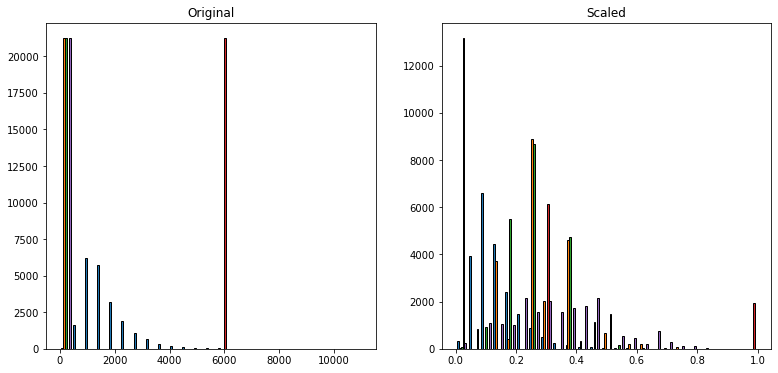

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')

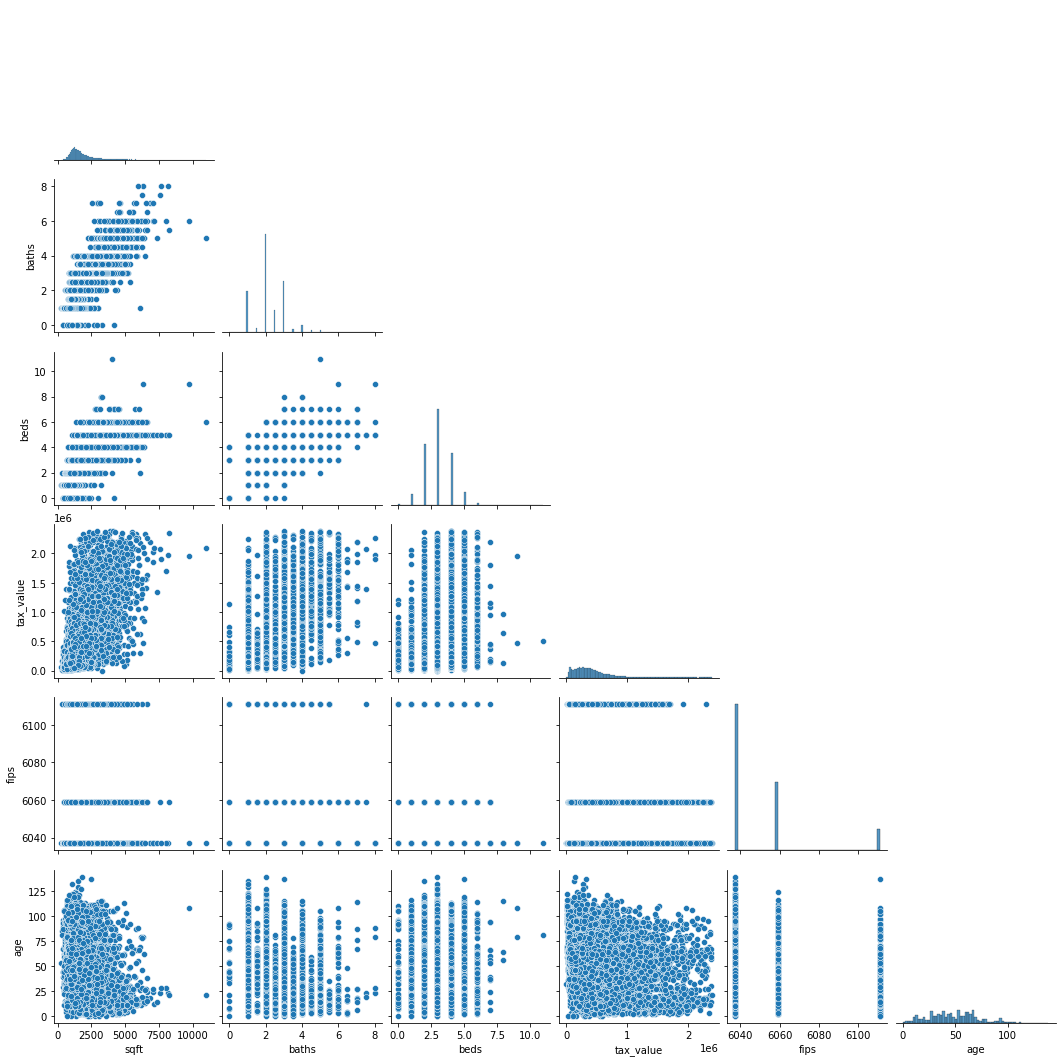

In [11]:
sns.pairplot(train[['sqft', 'baths', 'beds', 'tax_value','fips','age']], corner=True)
plt.show()

In [12]:
cols = ['sqft', 'baths', 'beds', 'tax_value','fips','age']

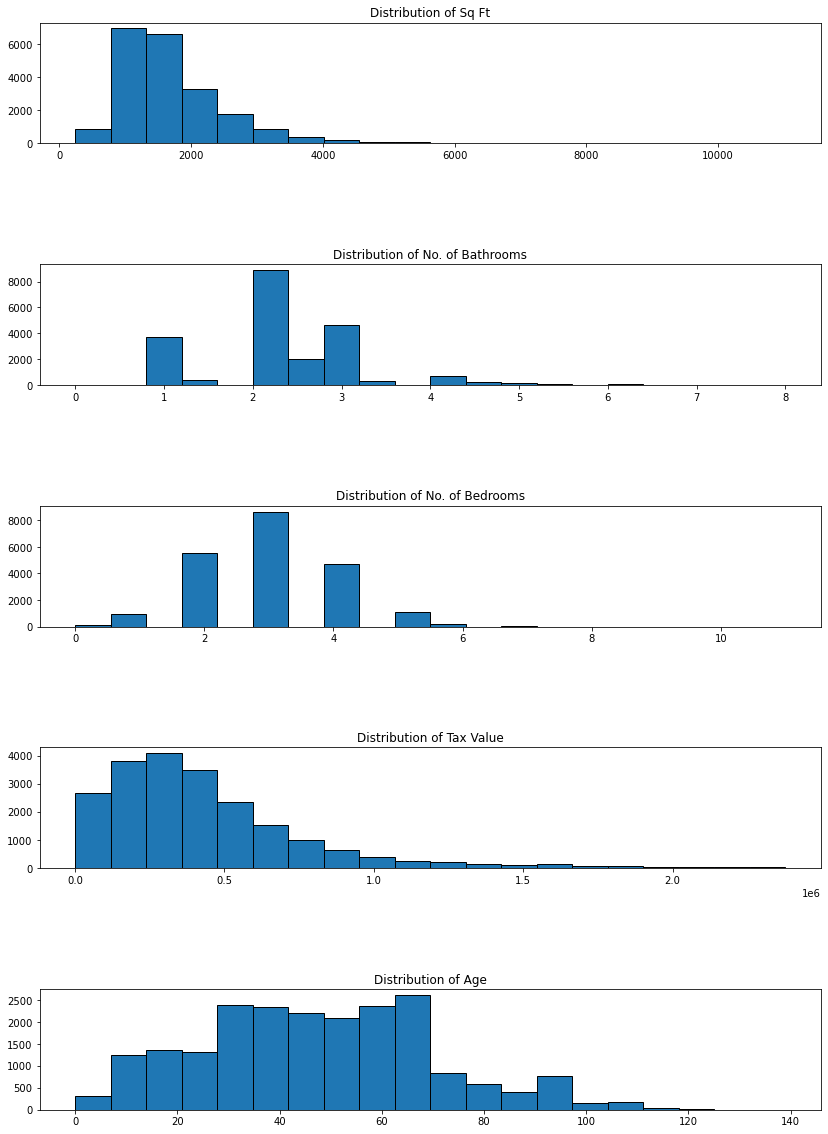

In [13]:
plt.figure(figsize=(14,20))
plt.subplot(5,1,1, title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft', bins = 20,ec='black')

plt.subplot(5,1,2, title='Distribution of No. of Bathrooms')
plt.hist(data=train, x='baths',bins = 20, ec='black')

plt.subplot(5,1,3, title='Distribution of No. of Bedrooms')
plt.hist(data=train, x='beds',bins = 20,ec='black')

plt.subplot(5,1,4, title='Distribution of Tax Value')
plt.hist(data=train, x='tax_value',bins = 20,ec='black')

plt.subplot(5,1,5, title='Distribution of Age')
plt.hist(data=train, x='age',bins = 20,ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

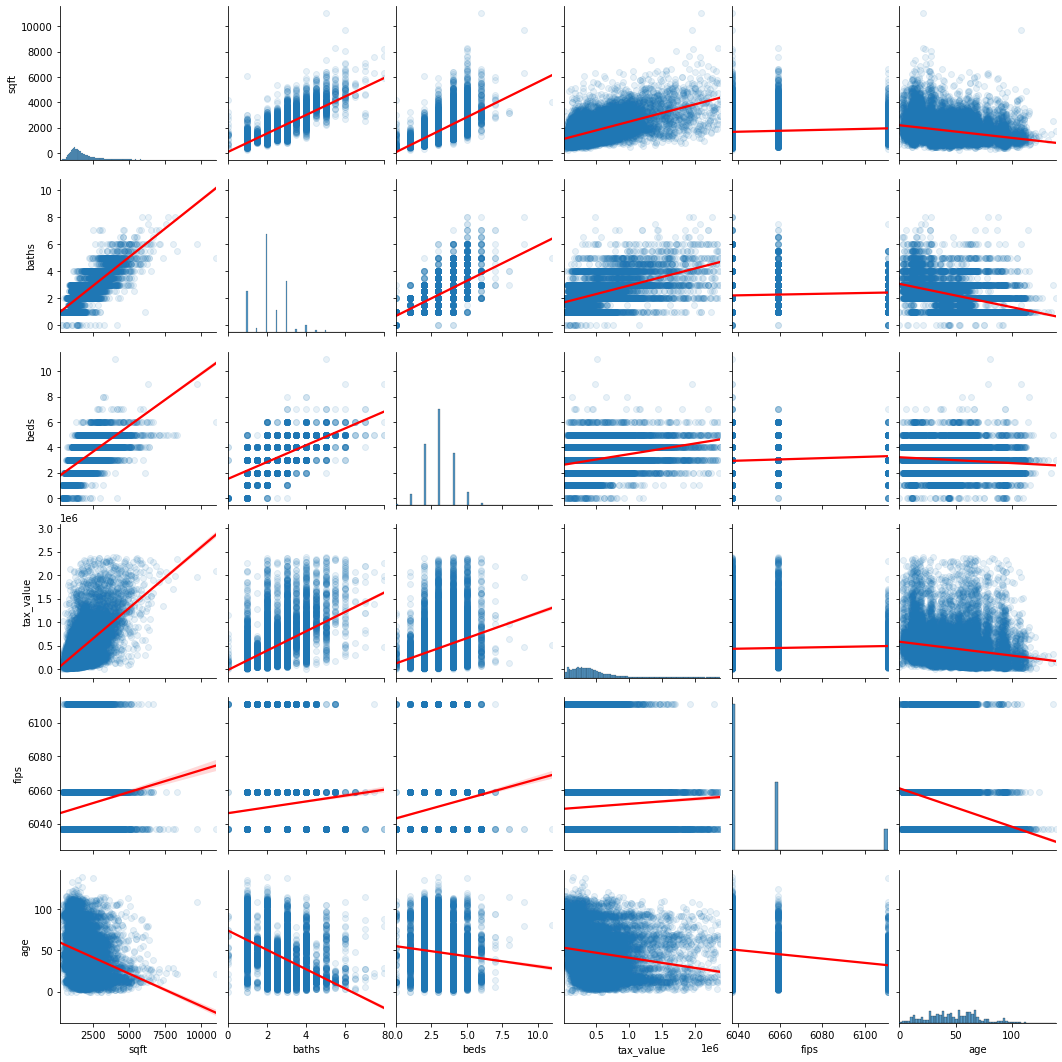

In [14]:
plot_variable_pairs(train, cols)

In [15]:
def get_zillow_heatmap(train):
    plt.figure(figsize=(8,12))
    heatmap = sns.heatmap(df.corr()[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-.5, vmax=.5, annot=True)
    heatmap.set_title('Feautures Correlating with Value')
    
    return heatmap

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

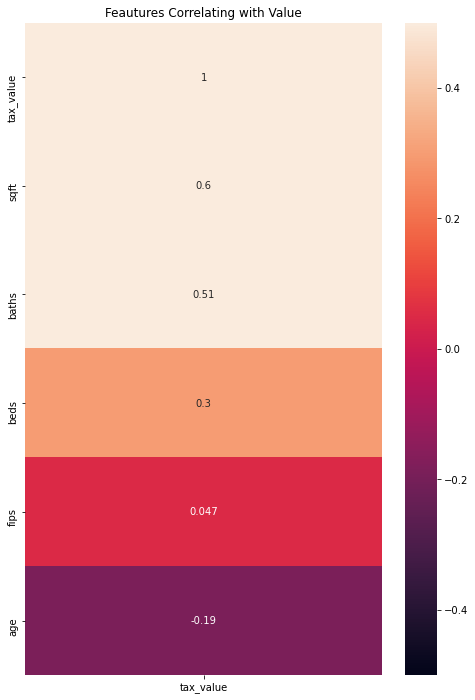

In [16]:
get_zillow_heatmap(train)

In [17]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.51


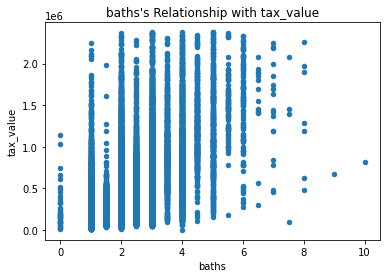

In [18]:
correlation_exploration(train, 'baths', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.3


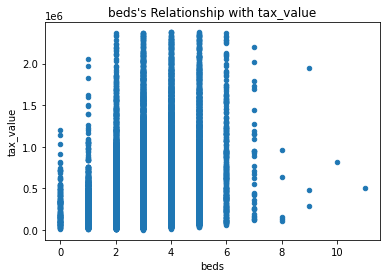

In [19]:
correlation_exploration(train, 'beds', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.68


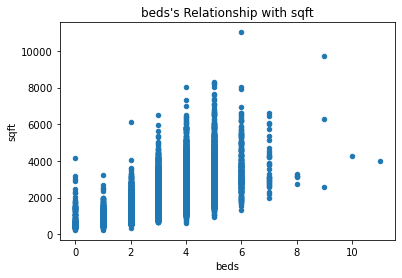

In [20]:
correlation_exploration(train, 'beds', 'sqft')


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.79


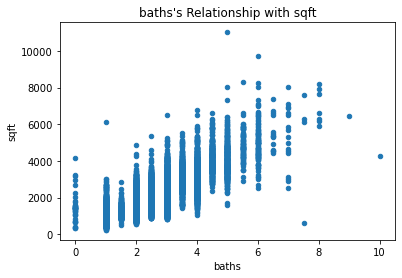

In [21]:
correlation_exploration(train, 'baths', 'sqft')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.6


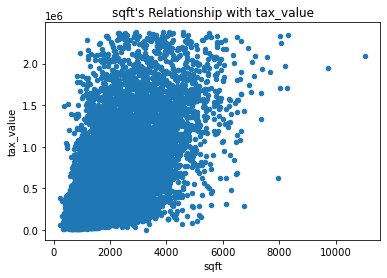

In [22]:
correlation_exploration(train, 'sqft', 'tax_value')

# Statistics

### Chose the 3 main categories for statistical analysis

1. Beds

2. Baths

3. Square Ft

𝐻0 : Houses with 2 bedrooms or more and houses with less than 2 bedrooms are independent to value of home

𝐻𝑎 : Houses with 2 bedrooms or more and houses with less than 2 bedrooms are related to value of home

In [23]:
null_hypothesis = "Houses with 2 bedrooms or more and houses with less than 2 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 2 bedrooms or more and houses with less than 2 bedrooms are related to value of home"
a = 0.05 #a for alpha 

two_or_more_beds = train[train.beds>=2]
less_than_two_beds = train[train.beds<2]
t, p = stats.ttest_ind(two_or_more_beds.tax_value, less_than_two_beds.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 2 bedrooms or more and houses with less than 2 bedrooms are independent to value of home
There is evidence to suggest: Houses with 2 bedrooms or more and houses with less than 2 bedrooms are related to value of home


In [24]:
null_hypothesis = "Houses with 2 bathrooms or more and houses with less than 2 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 2 bathrooms or more and houses with less than 2 bathrooms are related to value of home"
a = 0.05 #a for alpha 

two_or_more_baths = train[train.baths>=2]
less_than_two_baths = train[train.baths<2]
t, p = stats.ttest_ind(two_or_more_baths.tax_value, less_than_two_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 2 bathrooms or more and houses with less than 2 bathrooms are independent to value of home
There is evidence to suggest: Houses with 2 bathrooms or more and houses with less than 2 bathrooms are related to value of home


In [25]:
train.sqft.mean() ## mean of sqft to determine footage for T test

1718.6587720124305

$H_0$: Houses > 1600 square feet are independent of their tax value price

$H_a$: Houses <= 1600 square feet have a significant outcome on their tax value price

In [26]:
null_hypothesis = "Houses > 1600 square feet are independent of their tax value price"
alternative_hypothesis = "Houses <= 1600 square feet have a significant outcome on their tax value price"
a = 0.05 #a for alpha 

big_house = train[train.sqft>1600]
small_house = train[train.baths<=1600]
t, p = stats.ttest_ind(big_house.tax_value, small_house.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses > 1600 square feet are independent of their tax value price
There is evidence to suggest: Houses <= 1600 square feet have a significant outcome on their tax value price



### Standard Hypothesis for correlation test of all variables

$H_0$ : There is no relationship between these variables

$H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [27]:
# Correlation between beds and tax value
corr, p = stats.pearsonr(train.beds, train.tax_value)
corr, p

(0.30038631675287975, 0.0)

In [28]:
# Correlation between baths and tax value
corr, p = stats.pearsonr(train.baths, train.tax_value)
corr, p


(0.5082016708488328, 0.0)

In [29]:
# correlation between sqft and tax value
corr, p = stats.pearsonr(train.sqft, train.tax_value)
corr, p

(0.5965152621614396, 0.0)

In [30]:
# correlation between baths and beds
corr, p = stats.pearsonr(train.baths, train.beds)
corr, p

(0.5871875600625194, 0.0)

In [31]:
# Correlation between baths and sqft
corr, p = stats.pearsonr(train.baths, train.sqft)
corr, p

(0.7872427734716594, 0.0)

In [32]:
# Corrlation between beds and sqft
corr, p = stats.pearsonr(train.beds, train.sqft)
corr, p

(0.675148984039787, 0.0)

### Statistical Testing Takeaways

The features we hypothesized would be good in model building have strong correlations with our target variable and proven to be significant from our correlation tests

By running t and p tests on our 3 main features as well after creating categories. We have determined that the 3 main features do have a significant impact on tax value

# Model

In [33]:
# Selecting the best features

f_selector = SelectKBest(f_regression, k=2)
X_reduced2 = SelectKBest(f_regression, k=2).fit_transform(X_train_scaled, y_train)
print(X_reduced2.shape)

(21238, 2)


In [34]:
f_selector.fit(X_train_scaled, y_train)
f_support = f_selector.get_support()
print(f_support) 

[ True  True False False False]


In [35]:
f_feature = X_train_scaled.loc[:,f_support].columns.tolist()

In [36]:
print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['sqft', 'baths']


In [37]:
cor = df.corr()
cor_target = abs(cor["tax_value"])

In [38]:
relevant_features = cor_target[cor_target>0.3]
relevant_features

sqft         0.597324
baths        0.509535
tax_value    1.000000
Name: tax_value, dtype: float64

In [39]:
#tells us which features we should keep
import statsmodels.api as sm
cols = list(X_train_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['sqft', 'baths', 'beds', 'age']


In [40]:
#using RFE
number_of_features_list=np.arange(1,7)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 4
Score with 4 features: 0.376712


In [41]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 4)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'age'], dtype='object')


In [42]:
selected_features = ['sqft', 'baths', 'beds', 'age']

## Establishing Mean and Median Baseline

In [43]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('BASELINE')
print('--------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('--------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

BASELINE
--------------------
RMSE using Mean
Train/In-Sample:  357185.61 
Validate/Out-of-Sample:  359454.06
--------------------
RMSE using Median
Train/In-Sample:  367038.13 
Validate/Out-of-Sample:  369101.89
-----------------------------
The R squared score for the baseline is -3.072081049992903e-06


In [44]:
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.6834686621


In [45]:
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
r2_score_lm

0.3946386945306427

In [46]:
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Lasso+Lars
Training/In-Sample:  280731.6019596922 
Validation/Out-of-Sample:  279675.51693743526


In [47]:
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
r2_score_lars

0.3946264281839741

In [48]:
#create model object
glm = TweedieRegressor(power =0, alpha=0.00)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using TweedieRegressor
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.68346835295


In [49]:
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
r2_score_glm

0.39463869453198086

In [50]:
#making polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

In [51]:
#okay let's do linear regression again
lm3 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm3.fit(X_train_degree3, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm3)**(1/2)

#predict validate
y_validate['tax_value_pred_lm3'] = lm3.predict(X_validate_degree3)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  276310.6526820274 
Validation/Out-of-Sample:  274076.30740976887


In [52]:
r2_score_lm3 = round(r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm3),2)
r2_score_lm3

0.42

Text(0.5, 1.0, 'Residuals')

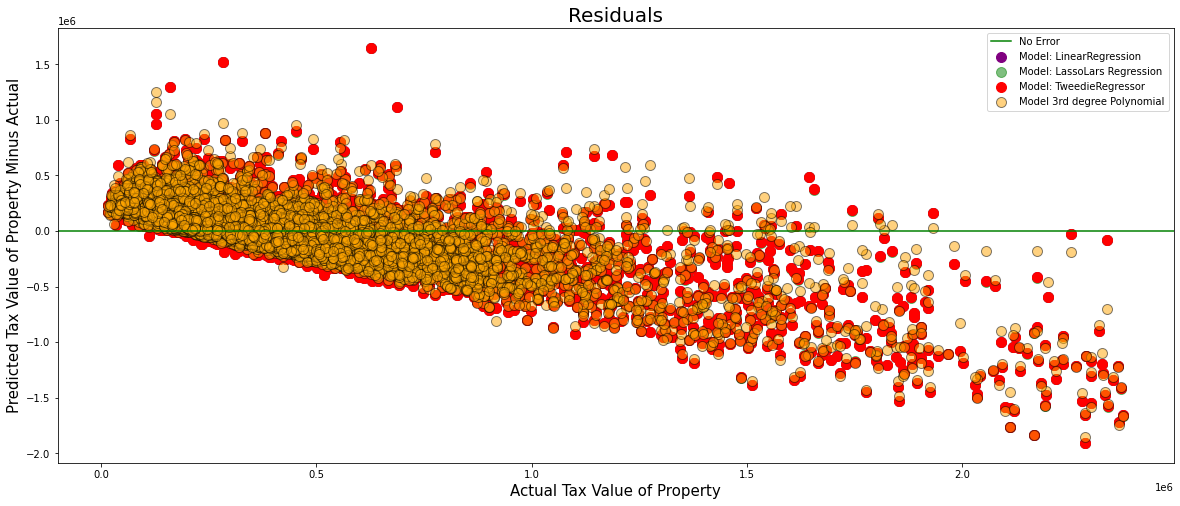

In [53]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="green")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=1, color="purple", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=1, color="red", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm3-y_validate.tax_value, 
            alpha=.5, color="orange", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

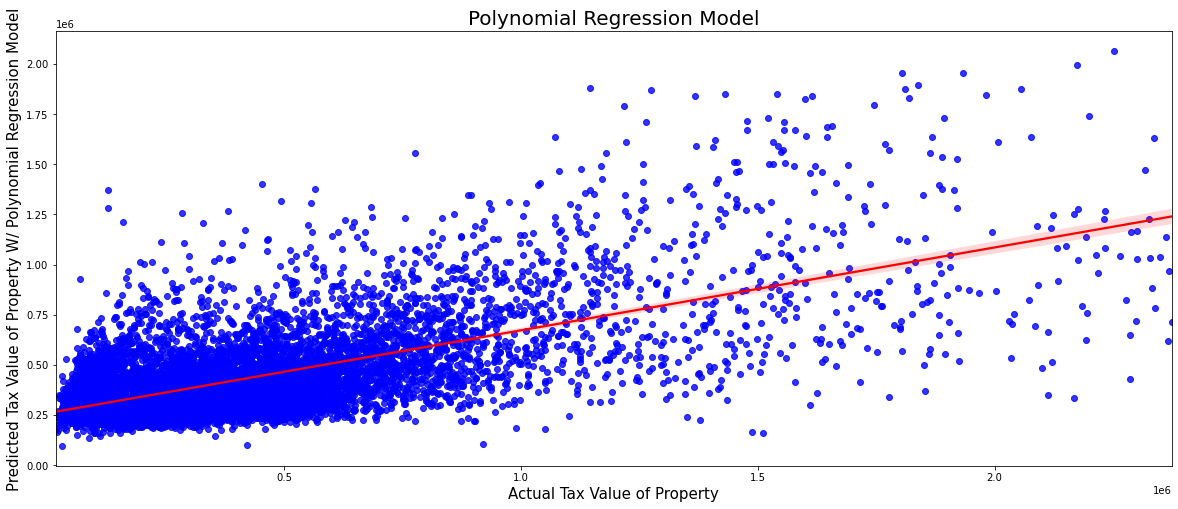

In [54]:
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm3, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property W/ Polynomial Regression Model", fontdict={'fontsize':15})
plt.title("Polynomial Regression Model", fontdict={'fontsize': 20})

plt.show()

In [57]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['tax_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm3)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Model using Polynomial (3 degrees)\nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm2 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm3)
print(f'Polynomial Regression (3 degrees) has an R^2 value of {round(r2_test_score_lm2,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Model using Polynomial (3 degrees)
Out-of-Sample Performance:  272168.2651014654
Polynomial Regression (3 degrees) has an R^2 value of 0.403
